# Cortex

In [111]:
from src.supervised_gcal.modules.lissom import *
from src.utils.images import *
from src.supervised_gcal.utils.images import *

In [112]:
in_features = 25**2
out_features = 5**2
cortex = Cortex(in_features, out_features, radius=5, sigma=5)

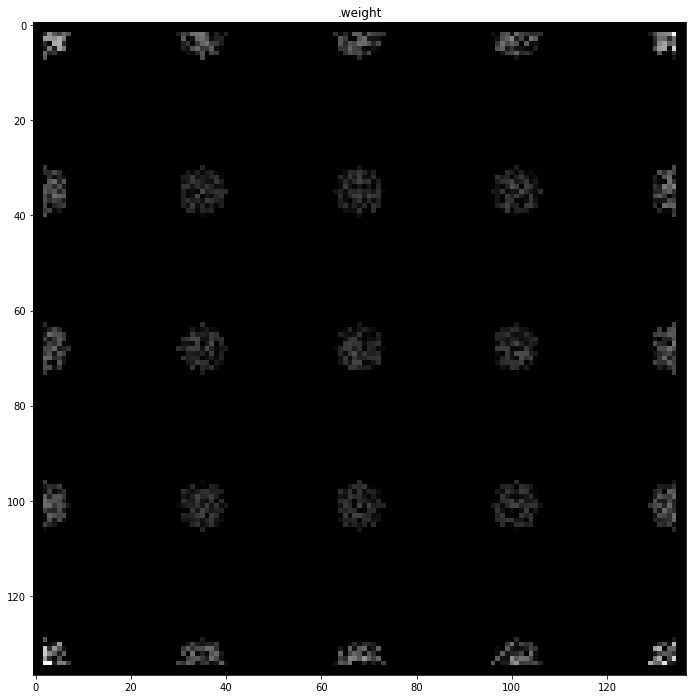

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plot_layer_weights(cortex, use_range=False)

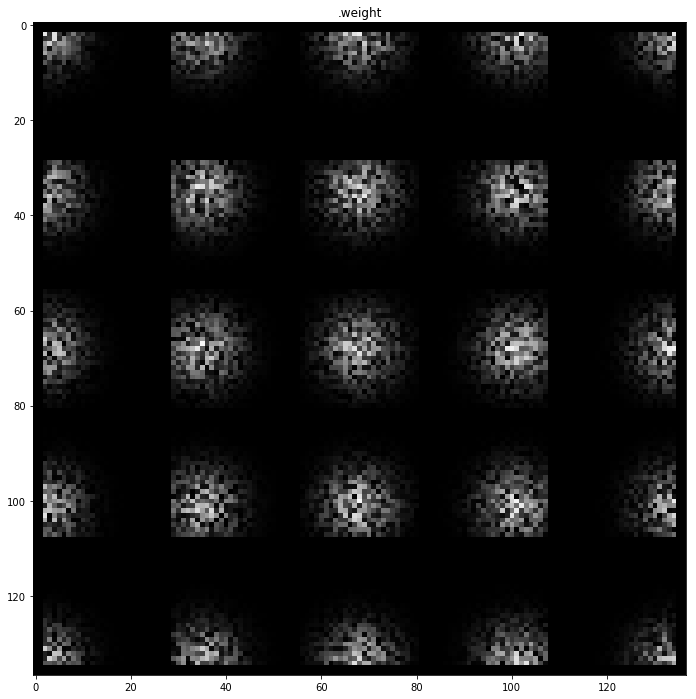

In [117]:
from src.supervised_gcal.modules.simple import *
gaussian_linear = GaussianCloudLinear(in_features, out_features, sigma=5)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plot_layer_weights(gaussian_linear)

# DiffOfGaussians

In [118]:
in_features = 25**2
out_features = 5**2
dofg = DifferenceOfGaussiansLinear(in_features, out_features, radius=5, on=False, sigma_surround=5, sigma_center=1)

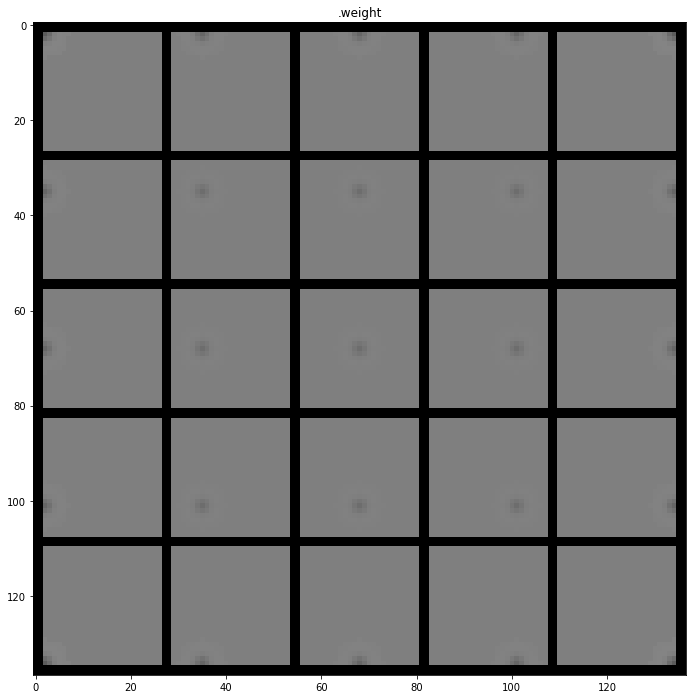

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plot_layer_weights(dofg, use_range=True)

In [120]:
in_features = 24**2
out_features = 5**2
unnorm_dofg = UnnormalizedDifferenceOfGaussiansLinear(in_features, out_features, on=False, sigma_surround=5, sigma_center=1)

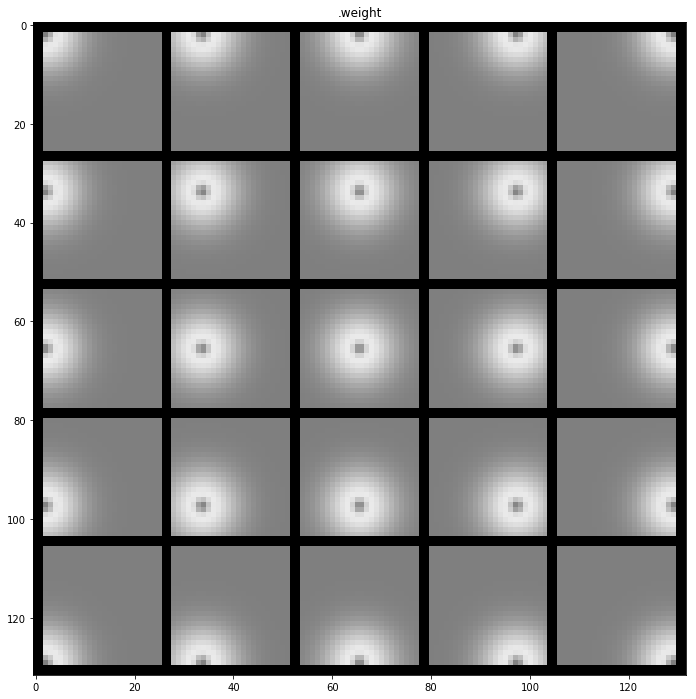

In [121]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plot_layer_weights(unnorm_dofg, use_range=True)

# LGN

In [122]:
retinal_density = 36
lgn_density = 36
radius_afferent = (lgn_density / 4 + 0.5)
scale_afferent = radius_afferent / 6.5  # radius_afferent_reference
radius_center_gaussian = 0.5*scale_afferent*retinal_density/lgn_density
radius_surround_gaussian = 4*radius_center_gaussian
radius_afferent_lgn = 4.7*radius_surround_gaussian

In [123]:
radius_center_gaussian

0.7307692307692307

In [124]:
radius_surround_gaussian

2.923076923076923

In [125]:
radius_afferent_lgn

13.738461538461538

In [126]:
in_features = retinal_density **2
out_features = lgn_density**2
off_test = LGN(in_features, out_features, 
          on=False, 
          radius=radius_afferent_lgn, 
                    sigma_surround=5, sigma_center=2)
on_test = LGN(in_features, out_features, 
          on=True, 
          radius=radius_afferent_lgn, 
          sigma_surround=radius_surround_gaussian, sigma_center=radius_center_gaussian)

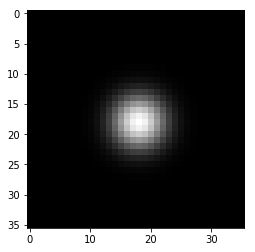

In [131]:
gauss_size = int(in_features**0.5)
sigma_x = 3
sigma_y = sigma_x
gauss = gaussian_generator(gauss_size, gauss_size//2, gauss_size//2, sigma_x, sigma_y, 0)
plot_matrix(gauss)
inp = torch.autograd.Variable(torch.from_numpy(gauss).view(in_features)).unsqueeze(0)

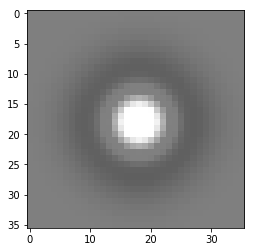

In [132]:
out_rows = int(out_features**0.5)
out = (on_test(inp) - off_test(inp)).data*2.33/1
mat = tensor_to_numpy_matrix(out, (out_rows,out_rows))
plt.imshow(mat, cmap='gray', vmin=-0.5, vmax=0.5)
plt.show()

# ReducedLissom

In [133]:
retinal_density = 36
lgn_density = retinal_density
cortical_density = 36
# Receptive Fields
radius_afferent = (lgn_density / 4 + 0.5)
radius_excitatory = (cortical_density / 10)
radius_inhibitory = cortical_density / 4 - 1
radius_gaussian_afferent = radius_afferent / 1.3
radius_gaussian_excitatory = 0.78 * radius_excitatory
radius_gaussian_inhibitory = 2.08 * radius_inhibitory
# Activation
settling_steps = 9
min_theta = 0.083
max_theta = min_theta + 0.55
# Scaling
afferent_factor = 1.0
excitatory_factor = 0.9
inhibitory_factor = 0.9

In [134]:
in_features = lgn_density**2
out_features = cortical_density**2
excitatory_map = Cortex(in_features, out_features, radius=radius_excitatory, sigma=radius_gaussian_excitatory)

In [135]:
in_features = cortical_density**2
out_features = cortical_density**2
afferent_map = Cortex(in_features, out_features, radius=radius_afferent, sigma=radius_gaussian_afferent)

In [136]:
in_features = cortical_density**2
out_features = cortical_density**2
inhibitory_map = Cortex(in_features, out_features, radius=radius_inhibitory, sigma=radius_gaussian_inhibitory)

In [137]:
v1 = ReducedLissom(afferent_module=afferent_map, excitatory_module=excitatory_map, inhibitory_module=inhibitory_map, 
                   min_theta=min_theta, max_theta=max_theta, settling_steps=settling_steps,
                  inhibitory_strength=inhibitory_factor, afferent_strength=afferent_factor, 
                   excitatory_strength=excitatory_factor)

In [138]:
print(repr(v1))

ReducedLissom (
  (inhibitory_module): Cortex (1296 -> 1296, sigma=16.64, radius=8.0)
  (excitatory_module): Cortex (1296 -> 1296, sigma=2.8080000000000003, radius=3.6)
  (afferent_module): Cortex (1296 -> 1296, sigma=7.3076923076923075, radius=9.5)
  (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.083, max_theta=0.633)
, 1296 -> 1296, settling_steps=9, afferent_strength=1.0, excitatory_strength=0.9, inhibitory_strength=0.9)


In [139]:
register_recursive_forward_hook(v1, input_output_hook)

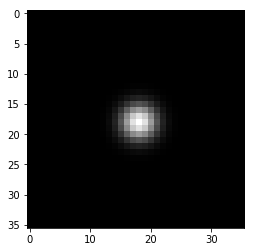

In [140]:
gauss_size = int(in_features**0.5)
gauss = gaussian_generator(gauss_size, gauss_size//2, gauss_size//2, 2, 2, 0)
plot_matrix(gauss)

In [141]:
inp = torch.autograd.Variable(torch.from_numpy(gauss).view(in_features)).unsqueeze(0)

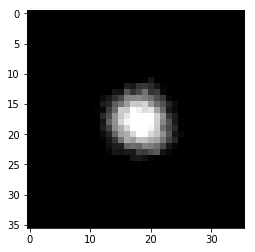

In [142]:
out_rows = int(out_features**0.5)
plot_tensor(v1(inp*2.33).data, (out_rows,out_rows))

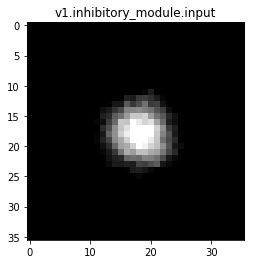

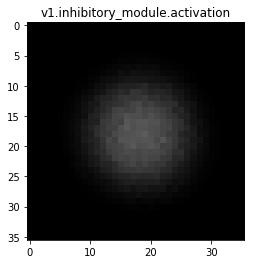

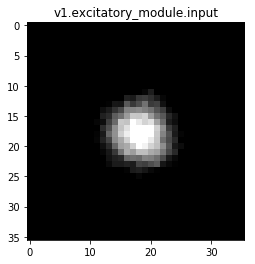

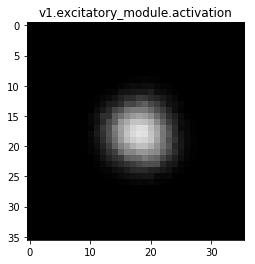

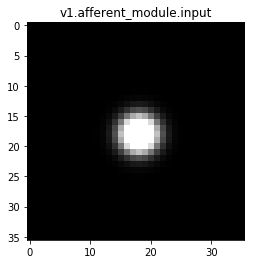

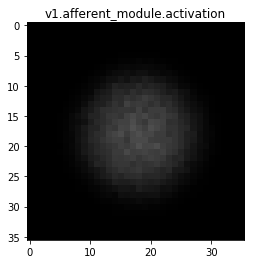

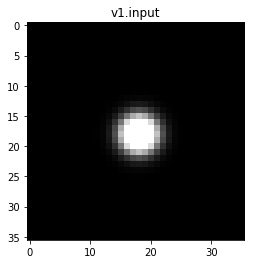

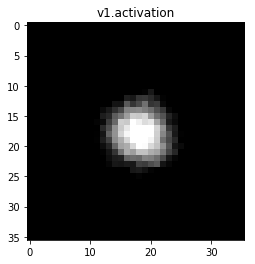

In [143]:
plot_layer_activation(v1, 'v1')

# Lissom

In [144]:
retinal_density = 36
lgn_density = 36
cortical_density = 36
# Receptive Fields
radius_afferent = (lgn_density / 4 + 0.5)
radius_excitatory = (cortical_density / 10)
radius_inhibitory = cortical_density / 4 - 1
radius_gaussian_afferent = radius_afferent / 1.3
radius_gaussian_excitatory = 0.78 * radius_excitatory
radius_gaussian_inhibitory = 2.08 * radius_inhibitory
# LGN
scale_afferent = radius_afferent / 6.5  # radius_afferent_reference
radius_center_gaussian = 0.5*scale_afferent*retinal_density/lgn_density
radius_surround_gaussian = 4*radius_center_gaussian
radius_afferent_lgn = 4.7*radius_surround_gaussian
# Activation
settling_steps = 9
min_theta = 0.083
max_theta = min_theta + 0.55
# Scaling
afferent_factor = 1.0
excitatory_factor = 0.9
inhibitory_factor = 0.9
lgn_factor = 2.33 / 1 #  (brightness scale of the retina, contrast of fully bright stimulus)

In [145]:
in_features = lgn_density**2
out_features = cortical_density**2
excitatory_map = Cortex(in_features, out_features, radius=radius_excitatory, sigma=radius_gaussian_excitatory)

In [146]:
in_features = cortical_density**2
out_features = cortical_density**2
afferent_map = Cortex(in_features, out_features, radius=radius_afferent, sigma=radius_gaussian_afferent)

In [147]:
in_features = cortical_density**2
out_features = cortical_density**2
inhibitory_map = Cortex(in_features, out_features, radius=radius_inhibitory, sigma=radius_gaussian_inhibitory)

In [148]:
v1 = ReducedLissom(afferent_module=afferent_map, excitatory_module=excitatory_map, inhibitory_module=inhibitory_map, 
                   min_theta=min_theta, max_theta=max_theta, settling_steps=settling_steps,
                  inhibitory_strength=inhibitory_factor, afferent_strength=afferent_factor, 
                   excitatory_strength=excitatory_factor)

In [149]:
in_features = retinal_density **2
out_features = lgn_density**2
off = LGN(in_features, out_features, 
          on=False, 
          radius=radius_afferent_lgn, 
                    sigma_surround=radius_surround_gaussian, sigma_center=radius_center_gaussian,
         strength=lgn_factor)
on = LGN(in_features, out_features, 
          on=True, 
          radius=radius_afferent_lgn, 
          sigma_surround=radius_surround_gaussian, sigma_center=radius_center_gaussian,
        strength=lgn_factor)

In [150]:
lissom = Lissom(on=on, off=off, v1=v1)

In [151]:
print(repr(lissom))

Lissom (
  (v1): ReducedLissom (
    (inhibitory_module): Cortex (1296 -> 1296, sigma=16.64, radius=8.0)
    (excitatory_module): Cortex (1296 -> 1296, sigma=2.8080000000000003, radius=3.6)
    (afferent_module): Cortex (1296 -> 1296, sigma=7.3076923076923075, radius=9.5)
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.083, max_theta=0.633)
  , 1296 -> 1296, settling_steps=9, afferent_strength=1.0, excitatory_strength=0.9, inhibitory_strength=0.9)
  (off): LGN (
    (diff_of_gaussians): DifferenceOfGaussiansLinear (1296 -> 1296, sigma_surround=2.923076923076923, sigma_center=0.7307692307692307, radius=13.738461538461538, on=False)
    (strength): *2.33
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.0, max_theta=1.0)
  )
  (on): LGN (
    (diff_of_gaussians): DifferenceOfGaussiansLinear (1296 -> 1296, sigma_surround=2.923076923076923, sigma_center=0.7307692307692307, radius=13.738461538461538, on=True)
    (strength): *2.33
    (piecewise_sigmoid): PiecewiseSigmoid (min_t

In [152]:
register_recursive_forward_hook(lissom, input_output_hook)

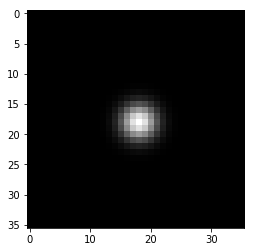

In [153]:
gauss_size = int(in_features**0.5)
gauss = gaussian_generator(gauss_size, gauss_size//2, gauss_size//2, 2, 2, 0)
plot_matrix(gauss)

In [154]:
inp = torch.autograd.Variable(torch.from_numpy(gauss).view(in_features)).unsqueeze(0)

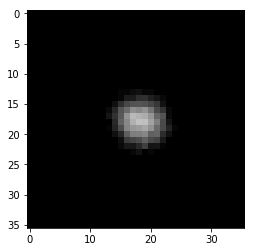

In [155]:
out_rows = int(out_features**0.5)
plot_tensor(lissom(inp).data, (out_rows,out_rows))

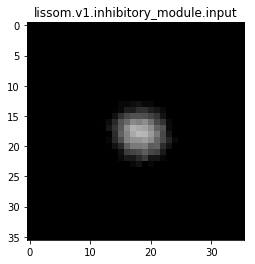

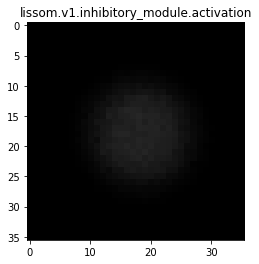

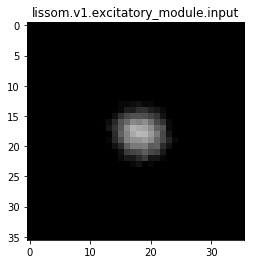

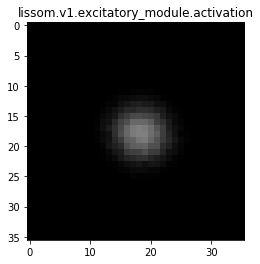

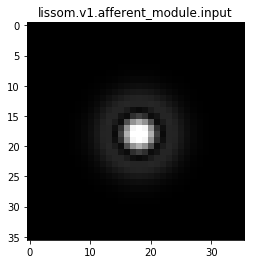

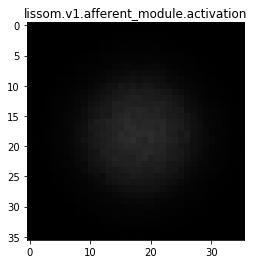

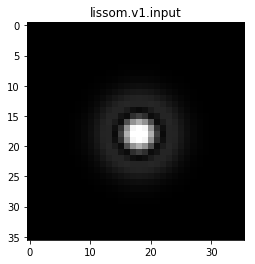

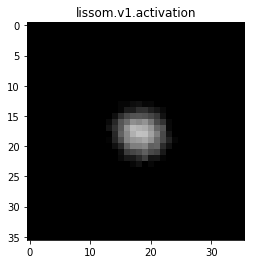

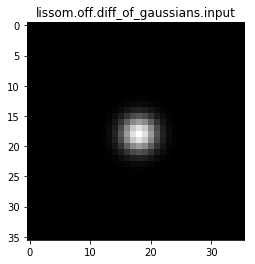

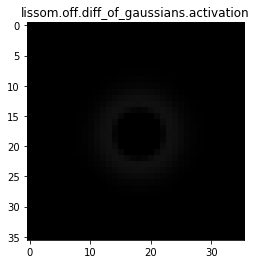

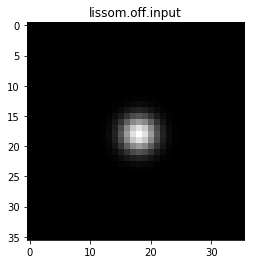

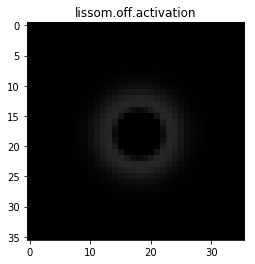

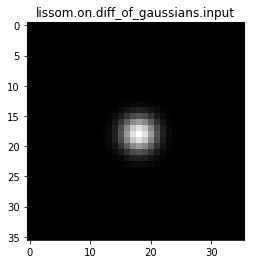

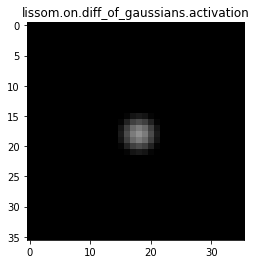

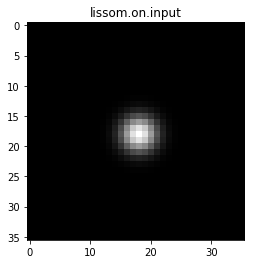

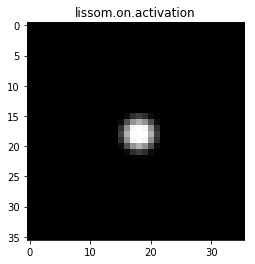

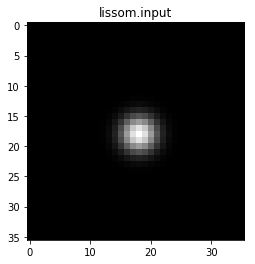

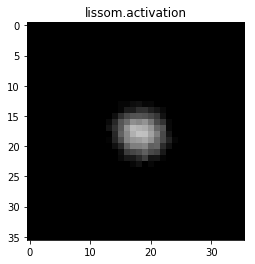

In [156]:
plot_layer_activation(lissom, 'lissom')

# Playground